In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import linalg
from scipy.sparse import save_npz
import scipy.io
from itertools import combinations
from numpy import linalg as LA

In [2]:
def inds_zerosector(dim, nmb_of_bits):
    c = np.array([tuple(c) for c in combinations(np.arange(dim),dim//2 + nmb_of_bits)]) 
    inds = np.zeros((c.shape[0],dim))
    for i in range(c.shape[0]):
        inds[i][c[i]] = 1 
    inds = inds.T
    inds_decimal = (np.int64(inds)*2**(np.arange(dim-1,-1,-1).reshape(dim,1))).sum(0)
    inds = inds[:,np.argsort(inds_decimal)]
    inds_decimal = np.sort(inds_decimal)
    inds_dic = {}
    i = 0
    for ind in inds_decimal:
        inds_dic[ind] = i
        i += 1
    return inds,inds_decimal,inds_dic

def inds_matrix(dim,inds,inds_decimal,inds_dic,x,mu):
    inds_row = []
    inds_column = []
    data_nondiag = []
    for i in range(dim-1):
        j = i+1
        signs = (-2*inds[i] + 1) * (-2*inds[j] + 1)
        inds_neg = np.nonzero((1-signs))[0]
        inds_row.extend(inds_neg)
        inds_row_cur = inds_decimal[inds_neg]
        inds_column_cur = np.int64(inds_row_cur-inds[i][inds_neg]*2**(dim-i-1) - inds[j][inds_neg]*2**(dim-j-1) + 
                               +(1-inds[i][inds_neg])*2**(dim-i-1)+(1-inds[j][inds_neg])*2**(dim-j-1))
        inds_nonzero = []
        for ind in inds_column_cur:
            inds_nonzero.append(inds_dic[ind])
        inds_column.extend(np.array(inds_nonzero))
        data_nondiag.extend([x]*len(inds_neg))

    data_diag = np.zeros(len(inds_dic))
    for i in range(dim):
        q = i%2
        states_zero = np.nonzero(inds[i] == q)[0]
        data_diag[states_zero] += mu


    for i in range(dim-1):
        for l in range(i+1):
            q = l%2
            states_zero = np.nonzero(inds[l] == q)[0]
            data_diag[states_zero] += 1


    for i in range(dim-1):
        for l1 in range(i+1):
            for l2 in range(l1+1,i+1):
                q1 = l1%2
                q2 = l2%2
                states_nonlocal = np.nonzero((inds[l1] == q1)*(inds[l2] == q2))[0]
                m_element = (1-2*q1)*(1-2*q2)
                data_diag[states_nonlocal] += 2*m_element
    
    inds_diag = list(inds_dic.values())
    
    return inds_row, inds_column, data_nondiag, inds_diag, data_diag 


def H_sparse(inds_row, inds_column, data_nondiag, inds_diag, data_diag):
    inds_row_all = []
    inds_column_all = []
    data_all = []
    inds_row_all.extend(inds_row)
    inds_row_all.extend(inds_diag)
    inds_column_all.extend(inds_column)
    inds_column_all.extend(inds_diag)
    data_all.extend(data_nondiag)
    data_all.extend(data_diag)
    return csr_matrix((data_all, (inds_row_all, inds_column_all)))
    

In [3]:
def diagonalization(dim, x, mu):
    nmb_of_bits = dim % 2

    inds,inds_decimal,inds_dic = inds_zerosector(dim, nmb_of_bits)
    inds_row, inds_column, data_nondiag, inds_diag, data_diag  = inds_matrix(dim,inds,inds_decimal,inds_dic,x,mu)
    H_sp = H_sparse(inds_row, inds_column, data_nondiag, inds_diag, data_diag)
    energy , state_sparce = linalg.eigsh(H_sp,k=1,which='SA')
    state_full = np.zeros(2**dim)
    state_full[inds_decimal] = state_sparce[:,0]
    return energy, state_full

In [4]:
def data(dim, x, mu, terms):
    psi = {}
    e = {}
    for i in range(terms+1):
        e[dim - terms +i], psi[dim - terms +i] = diagonalization(dim-terms + i, x, mu)
    for i in range(terms+1):
        bit = np.zeros(dim - terms + i)
        for j in range(dim - terms + i):
            if j%2 == 0:
                bit[j] = 1
        a = 2**np.arange(dim - terms + i - 1, -1,-1)
        num_bit = bit*a 
        num_bit = num_bit.sum()
    
        if psi[dim - terms + i][int(num_bit)] < 0:
            psi[dim - terms + i] = -psi[dim - terms + i]
    
    return e, psi

In [5]:
def T(psi):
    params = psi.shape
    #print(params)
    psi = psi.reshape(-1)
    i = np.arange(psi.shape[0])
    psi2 = np.zeros(psi.shape[0])
    for i in range(psi.shape[0]):
        psi2[i] = psi[psi.shape[0] - i -1]
    return psi2.reshape(params)

In [6]:
def W_6terms(dim):
    Weights = {}

    Weights["001011", dim] = psi[dim - 6].dot(psi[dim][2**(dim-3)+2**(dim-5) + 2**(dim-6):2**(dim-3)+2**(dim-4)])

    for i in np.arange(dim,dim -3, -1):
        Weights["0011", i] = psi[i-4].dot(psi[i][2**(i - 3)+2**(- 4+i) : 2**(- 2+i)])

    for i in np.arange(dim, dim -5, -1):
        Weights["01", i] = psi[i-2].dot(psi[i][2**(i-2):2**(i-1)])

    for i in np.arange(dim, dim -5, -1):
        Weights["10", i] = psi[i-2].dot(psi[i][2**(i-1): 2**(i-2)+2**(i-1)])


    for i in np.arange(dim, dim -4, -1):
        Weights["110", i] = T(psi[i-3]).dot(psi[i][2**(i-1)+2**(i-2): 2**(i-1)+2**(i-2)+2**(i-3)])

    for i in np.arange(dim, dim -2, -1):
        Weights["11100",i] = T(psi[i-5]).dot(psi[i][2**(i-1)+2**(i-2)+2**(i-3):2**(i-1)+2**(i-2)+2**(i-3)+2**(i-5)])

    for i in np.arange(dim, dim -6, -1):
        Weights["f",i] = T(psi[i-1]).dot(psi[i][2**(i-1):])

    return Weights

In [7]:
def W_11terms(dim):
    Weights = {}

    for i in np.arange(dim, dim -3, -1):
        Weights["001011", i] = psi[i - 6].dot(psi[i][2**(i-3)+2**(i-5) + 2**(i-6):2**(i-3)+2**(i-5) + 2**(i-6)+2**(i-6)])

    for i in np.arange(dim,dim -5, -1):
        Weights["0011", i] = psi[i-4].dot(psi[i][2**(i - 3)+2**(- 4+i) : 2**(- 2+i)])

    for i in np.arange(dim, dim -7, -1):
        Weights["01", i] = psi[i-2].dot(psi[i][2**(i-2):2**(i-1)])

        
        
    for i in np.arange(dim, dim -3, -1):
        Weights["10001011", i] = psi[i-8].dot(psi[i][2**(i-1) + 2**(i-5) + 2**(i-7) + 2**(i-8): 2**(i-1) + 2**(i-5) + 2**(i-7) + 2**(i-8)+2**(i-8)])

    for i in np.arange(dim, dim -3, -1):
        Weights["100011", i] = psi[i-6].dot(psi[i][2**(i-1)+2**(i-5) + 2**(i-6): 2**(i-1)+2**(i-5) + 2**(i-6) + 2**(i-6)])

    for i in np.arange(dim, dim -5, -1):
        Weights["1001", i] = psi[i-4].dot(psi[i][2**(i-1) + 2**(i-4): 2**(i-1) + 2**(i-4) + 2**(i-4)])

    for i in np.arange(dim, dim -5, -1):
        Weights["1010", i] = psi[i-4].dot(psi[i][2**(i-1) + 2**(i-3):2**(i-1) + 2**(i-3) + 2**(i-4)])

    for i in np.arange(dim, dim -4, -1):
        Weights["10110", i] = T(psi[i-5]).dot(psi[i][2**(i-1) + 2**(i-3) + 2**(i-4): 2**(i-1) + 2**(i-3) + 2**(i-4) + 2**(i-5)])

    for i in np.arange(dim, dim -2, -1):
        Weights["1011100", i] = T(psi[i-7]).dot(psi[i][2**(i-1) + 2**(i-3) + 2**(i-4) + 2**(i-5):2**(i-1) + 2**(i-3) + 2**(i-4) + 2**(i-5) + 2**(i-7)])

        
        
    for i in np.arange(dim, dim -6, -1):
        Weights["110", i] = T(psi[i-3]).dot(psi[i][2**(i-1)+2**(i-2): 2**(i-1)+2**(i-2)+2**(i-3)])

    for i in np.arange(dim, dim -4, -1):
        Weights["11100",i] = T(psi[i-5]).dot(psi[i][2**(i-1)+2**(i-2)+2**(i-3):2**(i-1)+2**(i-2)+2**(i-3)+2**(i-5)])

    for i in np.arange(dim, dim -9, -1):
        Weights["f",i] = T(psi[i-1]).dot(psi[i][2**(i-1):])
        Weights["g",i] = psi[i-2].dot(psi[i][2**(i-1):2**(i-1) + 2**(i-2)])

    return Weights

In [8]:
def Ham_6terms(N,x,mu, Weights):
    H = np.zeros((6,6))
    H[0,0] = e[N-6] + 5 + 2*mu
    H[1,1] = e[N-4] + 3 + 2*mu
    H[2,2] = e[N-2] + 1 + 2*mu
    H[3,3] = e[N-2] 
    H[4,4] = e[N-3] + 1 + 2*mu
    H[5,5] = e[N-5] + 3 + 2*mu
    H[0,1] = x*Weights["01", N-4]
    H[0,2] = x*Weights["0011", N-2]
    H[1,2] = x*Weights["01", N-2]
    H[2,3] = x
    H[3,4] = x*Weights["f", N-2]
    H[4,5] = x*Weights["01",N-3]
    H[1,0] = x*Weights["01", N-4]
    H[2,0] = x*Weights["0011", N-2]
    H[2,1] = x*Weights["01", N-2]
    H[3,2] = x
    H[4,3] = x*Weights["f", N-2]
    H[5,4] = x*Weights["01",N-3]
    return H

In [9]:
def Ham_11terms(N,x,mu, Weights):
    H = np.zeros((11,11))
    H[0,0] = e[N-6] + 5 + 2*mu
    H[1,1] = e[N-4] + 3 + 2*mu
    H[2,2] = e[N-2] + 1 + 2*mu
    
    H[3,3] = e[N-8] + 5 + 2*mu
    H[4,4] = e[N-6] + 3 + 2*mu
    H[5,5] = e[N-4] + 1 + 2*mu
    H[6,6] = e[N-4]
    H[7,7] = e[N-5] + 1 + 2*mu
    H[8,8] = e[N-7] + 3 + 2*mu
    
    H[9,9] = e[N-3] + 1 + 2*mu
    H[10,10] = e[N-5] + 3 + 2*mu
    
    
    H[0,1] = x*Weights["01", N-4]
    H[0,2] = x*Weights["0011", N-2]
    H[1,2] = x*Weights["01", N-2]
    
    H[2,3] = x*Weights["10001011", N-2]
    H[2,4] = x*Weights["0011", N-2]
    H[2,5] = x*Weights["01",N-2]
    
    H[2,6] = x*Weights["g",N-2]
    
    H[2,7] = x*Weights["110",N-2]
    H[2,8] = x*Weights["11100",N-2]
    H[6,9] = x*Weights["f",N-3]
    H[7,9] = x*Weights["01",N-3]
    H[8,9] = x*Weights["0011",N-3]
    H[3,4] = x*Weights["01",N-6]
    H[3,5] = x*Weights["0011",N-4]
    H[7,8] = x*Weights["01",N-5]
    H[9,10] = x*Weights["01",N-3]
    
    H[5,6] = x
    H[6,5] = x
    H[6,7] = x*Weights["f",N-4]
    H[7,6] = x*Weights["f",N-4]
    H[4,5] = x*Weights["01",N-4]
    H[5,4] = x*Weights["01",N-4]
    
    
    H[1,0] = x*Weights["01", N-4]
    H[2,0] = x*Weights["0011", N-2]
    H[2,1] = x*Weights["01", N-2]
    
    H[3,2] = x*Weights["10001011",N-2]
    H[4,2] = x*Weights["0011", N-2]
    H[5,2] = x*Weights["01",N-2]
    H[6,2] = x*Weights["g",N-2]
    H[7,2] = x*Weights["110",N-2]
    H[8,2] = x*Weights["11100",N-2]
    H[9,6] = x*Weights["f",N-3]
    H[9,7] = x*Weights["01",N-3]
    H[9,8] = x*Weights["0011",N-3]
    H[4,3] = x*Weights["01",N-6]
    H[5,3] = x*Weights["0011",N-4]
    H[8,7] = x*Weights["01",N-5]
    H[10,9] = x*Weights["01",N-3]
    

    return H

In [10]:
def Energy_6terms(start, final, x, mu):
    Weights = W_6terms(start-1)
    for i in np.arange(start,final):
        H = Ham_6terms(i,x,mu,Weights)
        en,h = LA.eigh(H)
        en1 = en[0]
        gs = h[:,0]

        Weights["001011",i] = gs[0]
        Weights["0011",i] = gs[1]
        Weights["01",i] = gs[2]
        Weights["10",i] = gs[3]
        Weights["110",i] = gs[4]
        Weights["11100",i] = gs[5]
        Weights["f", i] = Weights["10", i]*(Weights["10", i-1]*Weights["f", i-2]+Weights["110",i-1]*Weights["01",i-2] + Weights["0011",i-2]*Weights["11100",i-1]) + Weights["110",i]*Weights["01",i-1] + Weights["11100",i]*Weights["0011",i-1]

        e[i] = en1
    return e

In [11]:
def Energy_11terms(start, final, x, mu):
    Weights = W_11terms(start-1)
    for i in np.arange(start,final):
        H = Ham_11terms(i,x,mu,Weights)
        en,h = LA.eigh(H)
        en1 = en[0]
        gs = h[:,0]

        Weights["001011",i] = gs[0]
        Weights["0011",i] = gs[1]
        Weights["01",i] = gs[2]
        Weights["10001011",i] = gs[3]
        Weights["100011",i] = gs[4]
        Weights["1001",i] = gs[5]
        Weights["1010",i] = gs[6]
        Weights["10110",i] = gs[7]
        Weights["1011100",i] = gs[8]
        Weights["110",i] = gs[9]
        Weights["11100",i] = gs[10]
        
        Weights["f", i] = ((Weights["100011", i]*Weights["11100", i-1] +Weights["1001", i]*Weights["110", i-1]
            +Weights["1010", i]*(Weights["1010",i-1]*Weights["f",i-4] + Weights["10110",i-1]*Weights["01",i-4]+ Weights["1011100",i-1]*Weights["0011",i-4])
            +Weights["10110",i]*Weights["1001",i-1] + Weights["1011100",i]*Weights["100011",i-1] + Weights["110",i]*Weights["01",i-1] + Weights["11100",i]*Weights["0011",i-1]))
        
        Weights["g",i] = ((Weights["10001011",i]*Weights["001011",i-2] + Weights["100011",i]*Weights["0011",i-2]+Weights["1001",i]*Weights["01",i-2]+
                          Weights["1010",i]*Weights["g",i-2] + Weights["10110",i]*Weights["110",i-2]+Weights["1011100",i]*Weights["11100",i-2]))
        
        e[i] = en1
    return e

In [12]:
x = 1
mu = 0.1
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)

In [13]:
x = 10
mu = 0
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)

In [14]:
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

In [15]:
x = 1
mu = 0
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD6_x1_m0_ = E

x = 1
mu = 0
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD11_x1_m0_ = E

x = 1
mu = 0.1
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD6_x1_m01_ = E

x = 1
mu = 0.1
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD11_x1_m01_ = E

#x = 10

x = 10
mu = 0
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD6_x10_m0_ = E

x = 10
mu = 0
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD11_x10_m0_ = E

x = 10
mu = 2.5
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD6_x10_m25_ = E

x = 10
mu = 2.5
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD11_x10_m25_ = E

#x = 100

x = 100
mu = 0
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD6_x100_m0_ = E

x = 100
mu = 0
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD11_x100_m0_ = E

x = 100
mu = 2.5
terms = 6
e,psi = data(18,x,mu,terms)
e = Energy_6terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD6_x100_m25_ = E

x = 100
mu = 2.5
terms = 11
e,psi = data(19,x,mu,terms)
e = Energy_11terms(19,307,x,mu)
E = {}
for i in np.arange(12,307):
    #print(e[i])
    E[i] = e[i]/i

AD11_x100_m25_ = E

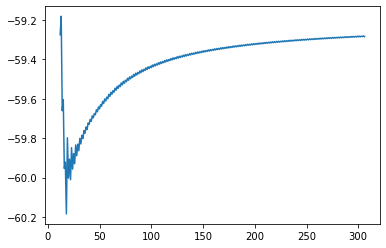

In [16]:
import matplotlib.pylab as plt

lists = sorted(E.items()) 
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [17]:
exact_x10_m25 = np.array([ -58.0255,   -68.2646,   -78.5062,   -88.7489,   -98.9921,  -150.2091,
          -201.4265,  -252.6438,  -406.2958,  -508.7304,  -764.8170, -1020.9037,
         -1276.9903, -1563.8073])
exact_x10_m0 = np.array([ -69.5819,   -81.7167,   -93.8621,  -106.0147,  -118.1724,  -178.9945,
          -239.8327,  -300.6731,  -483.1951,  -604.8765,  -909.0800, -1213.2834,
         -1517.4869, -1858.1948])
exact_x100_m25 = np.array([ -711.2917,   -835.2465,   -959.2649,  -1083.3279,  -1207.4241,
          -1828.2040,  -2449.2478,  -3070.4105,  -4934.1245,  -6176.6444,
          -9282.9572, -12389.2713, -15495.5854, -18974.6573])
exact_x100_m0 = np.array([-725.8484,   -852.1982,   -978.6049,  -1105.0506,  -1231.5242,
          -1864.1365,  -2496.9708,  -3129.9237,  -5029.0974,  -6295.3063,
          -9460.8839, -12626.4723, -15792.0613, -19337.5209])
exact_x1_m0 = np.array([ -5.0478,   -5.9427,   -6.8375,   -7.7324,   -8.6273,  -13.1016,
          -17.5758,  -22.0501,  -35.4730,  -44.4216,  -66.7930,  -89.1645,
         -111.5359, -136.5919])
exact_x1_m01 = np.array([   -4.7455,   -5.5886,   -6.4317,   -7.2749,   -8.1180,  -12.3335,
          -16.5491,  -20.7647,  -33.4113,  -41.8425,  -62.9203,  -83.9981,
         -105.0759, -128.6831])
x = np.array([12,14,16,18,20,30,40,50,80,100,150,200,250,306])

In [22]:
list = sorted(AD6_x1_m0_.items()) 
t, AD6_x1_m0 = zip(*list)

list = sorted(AD11_x1_m0_.items()) 
t, AD11_x1_m0 = zip(*list)

list = sorted(AD6_x1_m01_.items()) 
t, AD6_x1_m01 = zip(*list)

list = sorted(AD11_x1_m01_.items()) 
t, AD11_x1_m01 = zip(*list)

list = sorted(AD6_x10_m0_.items()) 
t, AD6_x10_m0 = zip(*list)

list = sorted(AD11_x10_m0_.items()) 
t, AD11_x10_m0 = zip(*list)

list = sorted(AD6_x10_m25_.items()) 
t, AD6_x10_m25 = zip(*list)

list = sorted(AD11_x10_m25_.items()) 
t, AD11_x10_m25 = zip(*list)


list = sorted(AD6_x100_m0_.items()) 
t, AD6_x100_m0 = zip(*list)

list = sorted(AD11_x100_m0_.items()) 
t, AD11_x100_m0 = zip(*list)

list = sorted(AD6_x100_m25_.items()) 
t, AD6_x100_m25 = zip(*list)

list = sorted(AD11_x100_m25_.items()) 
t, AD11_x100_m25 = zip(*list)

In [28]:
AD11_x1_m0_

{12: array([-0.42065388]),
 13: array([-0.42271203]),
 14: array([-0.42447812]),
 15: array([-0.42600793]),
 16: array([-0.42734685]),
 17: array([-0.4285281]),
 18: array([-0.42957816]),
 19: -0.43002485702834153,
 20: -0.4308950617808981,
 21: -0.43156783404440596,
 22: -0.43215002285764864,
 23: -0.4324535382795924,
 24: -0.4330222059361131,
 25: -0.43346087781792564,
 26: -0.4338251496770754,
 27: -0.43406196757218063,
 28: -0.4344473985963183,
 29: -0.4347552441316098,
 30: -0.4350092675259114,
 31: -0.4352030240029303,
 32: -0.4354755371099365,
 33: -0.43570268838143844,
 34: -0.4358942501481692,
 35: -0.43605518290732614,
 36: -0.4362571859124887,
 37: -0.4364313604347907,
 38: -0.43658265365990334,
 39: -0.4367179974829178,
 40: -0.43687349000920983,
 41: -0.4370122407870067,
 42: -0.43713527034491806,
 43: -0.43724949961550674,
 44: -0.43737359486301364,
 45: -0.4374868388522924,
 46: -0.4375898491521709,
 47: -0.43768666679156687,
 48: -0.43778804160041807,
 49: -0.4378827265

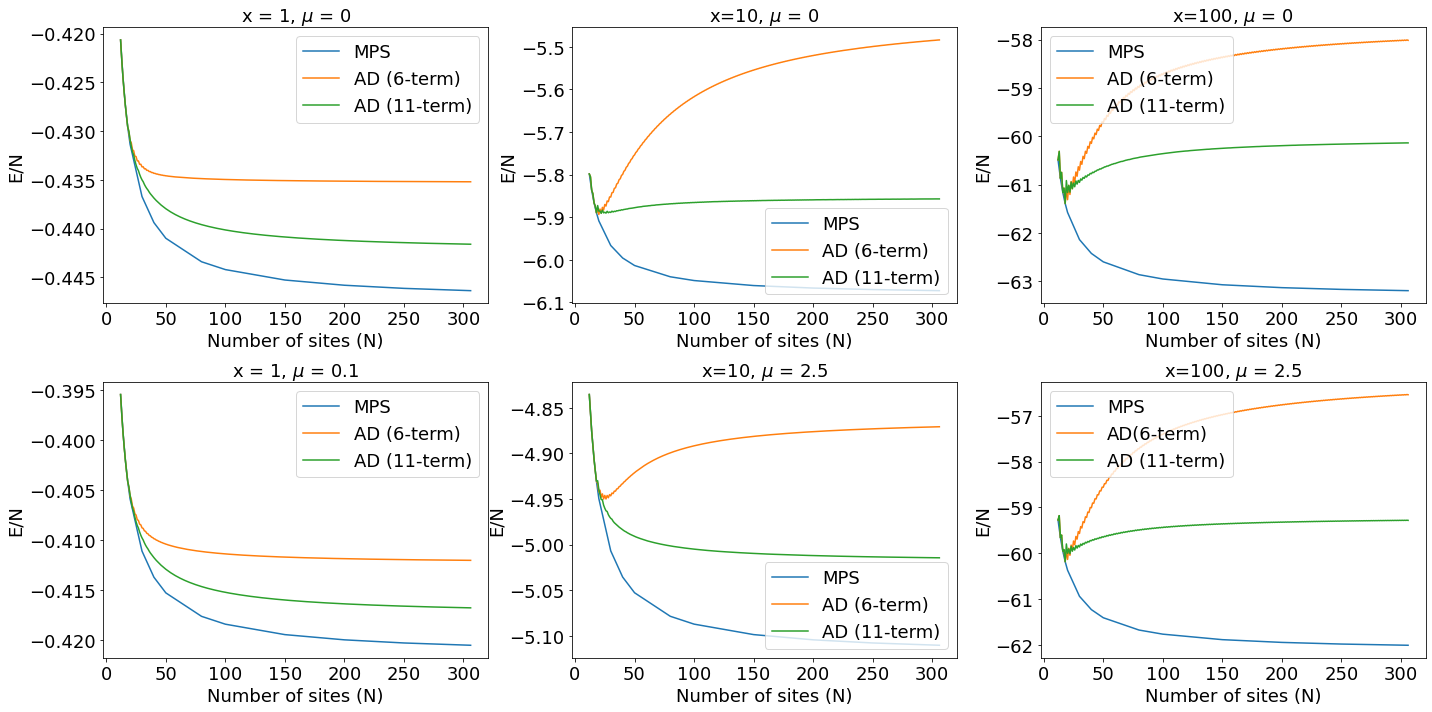

In [31]:
fig,ax = plt.subplots(2,3,figsize = (20,10))
size = 18

ax[0,0].plot(x,exact_x1_m0/x, label = 'MPS')
# N = np.arange(18-6,307,1)
# ax[0,0].plot(N,E9_x1_m0/N, label = 'AFW (9-term)')
# N = np.arange(18-8,307,1)
# ax[0,0].plot(N,E11_x1_m0/N, label = 'AFW (11-term)')
t = np.arange(12,307)
ax[0,0].plot(t,AD6_x1_m0, label = 'AD (6-term)')
t = np.arange(12,307)
ax[0,0].plot(t,AD11_x1_m0, label = 'AD (11-term)')
ax[0,0].legend(fontsize=size)

ax[0,0].set_title('x = 1, $\mu$ = 0', fontsize=size)

N = np.arange(18-6,307,1)
ax[1,0].plot(x,exact_x1_m01/x, label = 'MPS')
# ax[1,0].plot(N,E9_x1_m01/N, label = 'AFW (9-term)')
# N = np.arange(18-8,307,1)
# ax[1,0].plot(N,E11_x1_m01/N, label = 'AFW (11-term)')
t = np.arange(12,307)
ax[1,0].plot(t,AD6_x1_m01, label = 'AD (6-term)')
t = np.arange(12,307)
ax[1,0].plot(t,AD11_x1_m01, label = 'AD (11-term)')
ax[1,0].legend(fontsize=size)
ax[1,0].set_title('x = 1, $\mu$ = 0.1', fontsize=size)

t = np.arange(12,307)
ax[0,1].plot(x,exact_x10_m0/x, label = 'MPS')
# N = np.arange(74,307,1)
# ax[0,1].plot(N,E9_x10_m0/N, label = 'AFW (9-term)')
# N = np.arange(80-8,307,1)
# ax[0,1].plot(N,E11_x10_m0/N,label = 'AFW (11-term)')
ax[0,1].plot(t, AD6_x10_m0, label = 'AD (6-term)' )
t = np.arange(12,307)
ax[0,1].plot(t, AD11_x10_m0,label = 'AD (11-term)' )
ax[0,1].set_title('x=10, $\mu$ = 0',fontsize=size)
ax[0,1].legend(fontsize=size)

t = np.arange(12,307)
ax[1,1].plot(x,exact_x10_m25/x, label = 'MPS')
# N = np.arange(74,307,1)
# ax[1,1].plot(N,E9_x10_m25/N, label = 'AFW (9-term)')
# N = np.arange(80-8,307,1)
# ax[1,1].plot(N,E11_x10_m25/N,label = 'AFW (11-term)')
ax[1,1].plot(t, AD6_x10_m25, label = 'AD (6-term)' )
t = np.arange(12,307)
ax[1,1].plot(t, AD11_x10_m25, label = 'AD (11-term)' )
ax[1,1].set_title('x=10, $\mu$ = 2.5', fontsize=size)
ax[1,1].legend(fontsize=size)


ax[0,2].plot(x,exact_x100_m0/x, label = 'MPS')
# #N = np.arange(100-6,1000,1)
# N = torch.arange(100-6,307,1)
# ax[0,2].plot(N,E9_x100_m0[:307-100+6]/N,label = 'AFW (9-term)')
# #N = np.arange(100-8,1000,1)
# N = np.arange(100-8,307,1)
# ax[0,2].plot(N,E11_x100_m0[:307-100+8]/N,label = 'AFW (11-term)')
t = np.arange(12,307)
ax[0,2].plot(t, AD6_x100_m0, label = 'AD (6-term)' )
t = np.arange(12,307)
ax[0,2].plot(t, AD11_x100_m0,label = 'AD (11-term)' )
ax[0,2].set_title('x=100, $\mu$ = 0', fontsize=size)
ax[0,2].legend(fontsize=size, loc = 'upper left')


ax[1,2].plot(x,exact_x100_m25/x, label = 'MPS')
# #N = np.arange(100-6,1000,1)
# N = torch.arange(100-6,307,1)
# ax[1,2].plot(N,E9_x100_m25[:307-100+6]/N,label = 'AFW (9-term)')
# #N = np.arange(100-8,1000,1)
# N = np.arange(100-8,307,1)
# ax[1,2].plot(N,E11_x100_m25[:307-100+8]/N,label = 'AFW (11-term)')
t = np.arange(12,307)
ax[1,2].plot(t,AD6_x100_m25, label = 'AD(6-term)' )
t = np.arange(12,307)
ax[1,2].plot(t, AD11_x100_m25, label = 'AD (11-term)' )
ax[1,2].set_title('x=100, $\mu$ = 2.5', fontsize=size)
ax[1,2].legend(fontsize=size, loc = 'upper left' )
for i in range(2):
      for j in range(3):
        ax[i,j].set_xlabel('Number of sites (N)',  fontsize=size)
        ax[i,j].set_ylabel('E/N',  fontsize=size)
        ax[i,j].tick_params(labelsize = size)
fig.tight_layout()
# fig.savefig('gr.pdf', dpi=500)
# fig.savefig('gr.png', dpi=500)


# Code
